# Introduction to Data Science and Systems 2019-2020<small><small>v20192020d</small></small>
## Lab 2: Computational Linear Algebra
#### - ***you should submit this notebook to Moodle along with one pdf file (see the end of the notebook and Moodle for instructions)***

#### University of Glasgow, BSJ & JHW, 2019

## Purpose of this lab
The Lab should (along with Lab 1) help you to:
* understand how data can be represented as points in vector space
* understand the effect of different vector norms
* apply the inner product to compute the angle between vectors
* apply linear maps to data/vectors (in particular maps that reduce dimensionality) and visualise the result
* compute eigenvectors and values
* solve a system of linear equations (a linear system)

## Guide

Lab 2 is structured as follows (with two main task sections):

>-    **Intro: The std Whisky dataset (from Lab 1)** 
>-    **Task A: Eigenvalue decomposition and SVD**
>-    **Task B: Solving linear systems**
>-    **Appendix: Marking Summary (and additional metadata)**

We recommend you read through the lab *carefully* and work through the tasks.

#### Material and resources 
- It is recommended to keep the lecture notes (from lecture 1 and lecture 2) open while doing this lab exercise. 
    * ... and you should, of course, be prepared to access some of the recommended material.
- If you are stuck, the following resources are very helpful:
 * [NumPy cheatsheet](https://github.com/juliangaal/python-cheat-sheet/blob/master/NumPy/NumPy.md)
 * [NumPy API reference](https://docs.scipy.org/doc/numpy-1.13.0/reference/)
 * [NumPy user guide](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.html)

#### Marking and Feedback
This assessed lab is marked using three different techniques;

- Autograded with feedback; you'll get immediate feedback.
- Autograded without (immediate) feedback (there will always be a small demo/test so you can be confident that the format of your answer is correct).
- Manually graded (by an actual human). This type of question generates a pdf file that must be uploaded to Moodle alongside the notebook. We do not provide individual feedback, but a model solution will be provided so you can see what was expected.

*Note*: auto-graded results are always provisional and subject to change in case there are significant issues (this will usually be in favor of the student).

#### Help \& Assistance
- This lab is graded and the lab assistants/lecturer can provide guidance but we can (and will) not give you the final answer or confirm your result [at least in normal circumstances...].

#### Plagiarism
- All submissions will be automatically compared against each other so make sure your submission represents an independent piece of work! We have provided a few checks to make sure that is indeed the case.



---


Let's import some useful Python packages and define a few custom functions...

In [1]:
# Standard imports
# Make sure you run this cell!
# NumPy
import numpy as np  
import binascii
import os
import sys
from uuid import getnode as get_mac

# Set up Matplotlib
import matplotlib as mpl   
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('figure', figsize=(8.0, 4.0), dpi=140)

# custom utils (you do not need to understand this!) 
from jhwutils.checkarr import array_hash, check_hash
import jhwutils.image_audio as ia
import jhwutils.tick as tick

tick.reset_marks()
tick_hidden = 0
tick_hidden_pass = 0
tick_visible = 0
tick_manual = 0

def case_crc(s, verbose=True):
    h_crc =  binascii.crc32(bytes(s.lower(), 'ascii'))
    if verbose:
        print(h_crc)
    return h_crc

# this command generaties a unique key for your system/computer/account
uuid_simple = (("%s") % get_mac())
uuid_str = ("%s\n%s\n%s\n%s\n%s\n") % (os.path,sys.path,sys.version,sys.version_info,get_mac())
uuid_system = case_crc(uuid_str,verbose=False) 

# ignore any warnings below, they don't affect the results
print("Everything imported OK")

Everything imported OK


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


---

**Mini-task**: provide your personal details in two variables:

* `student_id` : a string containing your student id (e.g. "1234567x"), must be 8 chars long.
* `student_typewritten_signature`: a string with your name (e.g. "Adam Smith") which serves as a declaration that this is your own work (read the declaration of originality when you submit on Moodle).

In [2]:
student_id = "S1423498" # your 8 char student id
student_typewritten_signature = "Heather Logan" # your full name, avoid spceical chars if possible


In [3]:
## We will print your info to a pdf file at the end of the notebook - 
# including the Declaration of Originality - which must be uploaded alongside 
# the actual notebook  you should also see two green "v [0 marks] 
# indicating that your info meet the basic std)

with tick.marks(0): # you don't get any credit for remembering your student id. This is just a test!
    assert(len(student_id)==8)

with tick.marks(0):  # you don't get any credit for remembering your own name! This is just a test!
    assert(len(student_typewritten_signature)>0)

---

## The familiar Whisky data

The dataset in `data/whisky.csv` is data from a number of whisky distilleries. For each distillery, there is a set of subjective judgements about the flavour characteristics of their product. The data comes from [this Strathclyde University research project](https://www.mathstat.strath.ac.uk/outreach/nessie/nessie_whisky.html).

Each distillery has been judged on twelve flavour indicators (like "smokiness" or "sweetness"), and they have been assigned values from 0-4, indicating the strength of that category as judged by an expert whisky drinker. These can be seen as 12D vectors, one vector per distillery. **Every distillery is represented as a point in twelve dimensional vector space.**

We also have a 2D array of the geographical locations of each distillery. The code below loads the data.

## Loading the data

In [4]:
## It is not necessary to understand this code to complete
# the exercise....
import pandas as pd

whisky_df = pd.read_csv("data/whiskies.txt")
whisky_df = whisky_df.sort_values(by="Distillery")
# extract the column and row names
distilleries = np.array(whisky_df["Distillery"])

columns = {name.lower(): index for index, name in enumerate(whisky_df.columns[2:-3])}

# split apart the data frame and form numpy arrays
locations = np.array(whisky_df.iloc[:, -2:])
whisky = np.array(whisky_df.iloc[:, 2:-3])

# fix wine column which is misnamed
columns["wine"] = columns["winey"]
del columns["winey"]
# force tie breaks
np.random.seed(2018)
whisky = whisky + np.random.normal(0, 0.1, whisky.shape)

---

## Viewing the data

We can see this whole dataset as a heatmap:

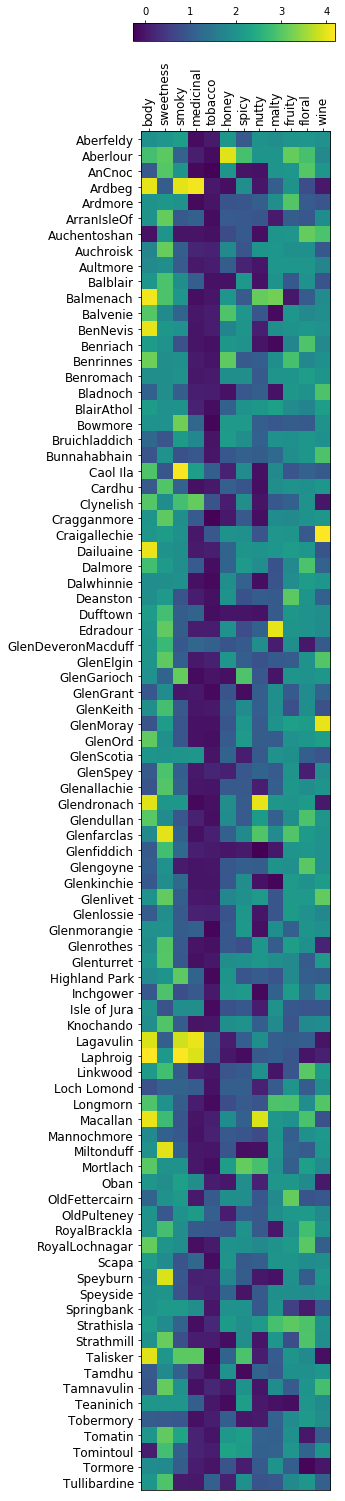

In [5]:
# show a plot of the whisky data
fig = plt.figure(figsize=(10,25))
ax = fig.add_subplot(1,1,1)

# image plot
img = ax.imshow(whisky)
ax.set_yticks(np.arange(len(distilleries)))
ax.set_yticklabels(distilleries, rotation="horizontal", fontsize=12)

# put the x axis at the top
ax.xaxis.tick_top()
ax.set_xticks(np.arange(len(columns)))
ax.set_xticklabels(columns, rotation="vertical", fontsize=12)

# some horrific colorbar hackery to put in the right place
# don't worry about this bit!
cbaxes = fig.add_axes([0.37, 0.93, 0.28, 0.01])  
fig.colorbar(img, orientation='horizontal',  cax=cbaxes, ticks=np.arange(5))
cbaxes.xaxis.tick_top()

---

### Available data
You now have these variables:

* `whisky` an  86x12 array of taste judgements, one row for each of the 86 distilleries. Each whisky has a rating 0-4 for each of the 12 flavour categories.
* `distilleries` is a list of 86 distillery names
* `columns` is a mapping of feature names to column indices.
* `locations` is an 86x2 matrix of positions of each distillery in [OS grid reference format](https://www.gridreferencefinder.com/) in the same order as `whisky`

The dataset that we have is unnormalised. It is a set of ratings, 0-4, and many of the attributes rated are very correlated (e.g. `smoky` and `medicinal`). Many of the ratings are also on quite different scales, with `tobacco` being much less likely to be rated 4 than `floral`.
It is easier to work with normalised data and we compute
* `mean_vector` the average flavour profile (you should have this from part A already)
* `demeaned_whisky` that has the mean flavour vector removed. 


In [6]:
mean_vector = np.mean(whisky, axis=0)
demeaned_whisky = whisky - mean_vector

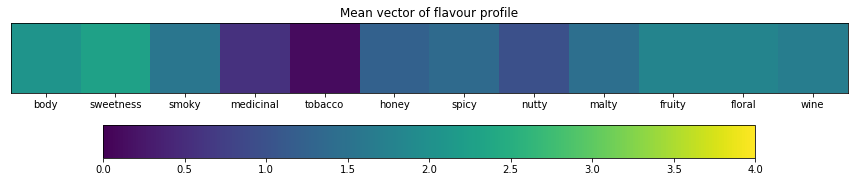

In [7]:
## Show the mean vector as an image strip
## Remember: this represents a point in space
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1,1,1)
img = ax.imshow(mean_vector[None,:], cmap='viridis', vmin=0, vmax=4)
ax.set_xticklabels(columns)
ax.set_xticks(np.arange(len(columns)))
ax.set_yticks([])
ax.set_title("Mean vector of flavour profile")
fig.colorbar(img, orientation='horizontal')

In [8]:
whisky_cov = np.cov(demeaned_whisky, rowvar=False) # rowvar=False means that the variables are columns, not rows. The values on the diagonal show the variance (std^2) of each variable. This hasn't been normalised yet.

We can also compute the **covariance matrix** of the *demeaned* data in `whisky_cov`. 
The covariance matrix tells us how different columns of the dataset are correlated (co-vary) with each other.

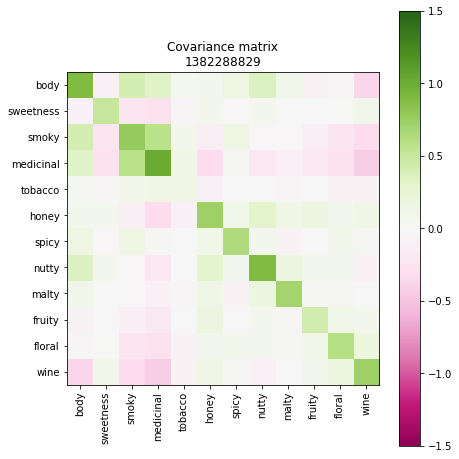

In [9]:
fig = plt.figure(figsize=(6, 6)) # Do not change the name of fig (this will be a two mark reduction!)
ax = fig.add_subplot(1,1,1)
img = ax.imshow(whisky_cov, cmap='PiYG', vmin=-1.5, vmax=1.5)
ax.set_xticks(np.arange(12))
ax.set_yticks(np.arange(12))
ax.set_yticklabels(columns)
ax.set_xticklabels(columns, rotation='vertical')
ax.set_title(("Covariance matrix\n%s") % (uuid_system))
fig.colorbar(img)
# resize the figure to match the aspect ratio of the Axes    
fig.set_size_inches(7, 8, forward=True)

---

# Tasks

### A: Eigendecomposition of the covariance matrix

We would like to create some new flavour categories that are independent of each other (so that we don't have categories like smoky and medicinal that are given similar numbers by the tasters). We can do this by combining the existing flavour categories.

By looking at the covariance matrix, we can get an idea of which flavours are most correlated or most independent. Let's analyse this in more detail. Recall that the covariance matrix can be represented by an ellipse whose primary axes are the **eigenvectors** of the covariance matrix. The eigenvectors are a set of *independent* directions in which the dataset varies. 

These are the **principal components** of the dataset. We can compute these from the covariance matrix by taking the eigendecomposition. Each eigenvector of the covariance matrix is a **principal component** and its importance is given by the square root of the absolute value of its corresponding eigenvalue.

Note that a 12 x 12 matrix will be represented by a 12-dimensional ellipsoid, which we can't really visualise, but we can visualise the relative importance of the eigenvectors. 

**Task A.1**
* Compute all 12 of the eigenvectors of the covariance matrix, in order, with the *largest* corresponding eigenvalue first. Store these as a matrix of column vectors in `whisky_pc`. These eigenvectors are the principal components of the whisky data set.
* Compute the square root of every eigenvalue (we can think of these as lengths of the prinicipal components) and store them in `whisky_pc_len`. Make sure they are in descending order from largest to smallest.

In [10]:
evals,evecs= np.linalg.eig(whisky_cov)
idx = np.argsort(-np.abs(evals))   
evals = evals[idx]
whisky_pc = evecs[:,idx]
whisky_pc_len = np.sqrt(evals)

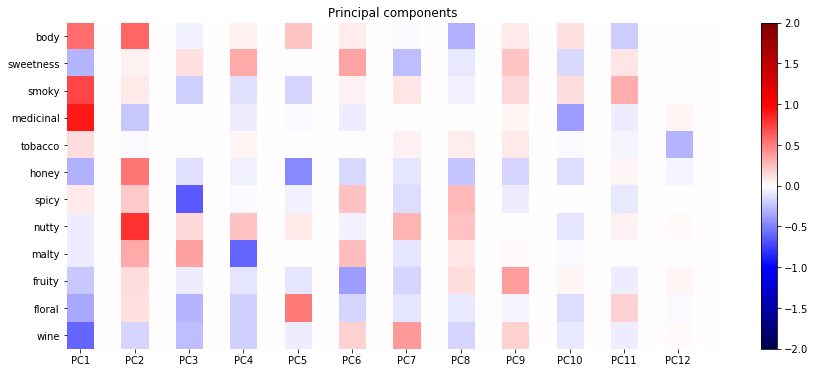

In [11]:
## We can show the principal components as an image
## Each row is a principal component and shows a vector
## which represents the direction of variation. The first
## vector represents the largest component.
fig_a1 = plt.figure(figsize=(15, 6))
ax = fig_a1.add_subplot(1,1,1)
# space out the principal components and scale them by the length of the components
img = ax.imshow(np.concatenate([(whisky_pc * whisky_pc_len), 
                                np.zeros_like(whisky_pc)], axis=0).T.reshape(24, -1).T, 
                cmap='seismic',         
                vmin=-2, vmax=2)

ax.set_yticks(np.arange(12))
ax.set_xticks(np.arange(0,24,2))
ax.set_xticklabels(["PC{i}".format(i=i+1) for i in np.arange(12)])
ax.set_yticklabels(columns)
ax.set_title("Principal components")
ax.set_frame_on(False)
fig_a1.colorbar(img);

In [12]:
## Visible, autograded assesment  (4 marks)


with tick.marks(4):    
    assert(check_hash(whisky_pc, ((12, 12), -116.3856770814677)))    

In [13]:
## Visible, autograded assesment (2 marks)


with tick.marks(2):        
    assert(check_hash(whisky_pc_len, ((12,), 49.2805781587291)))

## Projecting onto the principal components
We learned in Lab 1 how to project onto vectors (not the eigenvectors exactly in that case!).This is interesting, but quite hard to interpret. One very useful technique is to project data onto a small number of principal components, to visualise the data. This forms a simplified version of the data, where the use of principal components means we can map the directions in the data which are most important to our visual axes. For example, we might map the first two principal components to a 2D $x,y$ plot.

This is a key technique in exploratory data analysis: **principal component analysis**. All it involves is using the principal components to find a simplified mapping onto a lower-dimensional space.

We can compute a projection of a dataset onto an arbitrary set of vectors by forming a matrix product:
$$P = XV,$$

Where $P$ is an $N\times k$ matrix that is the result of the projection, $X$ is the $N \times D$ original data set and $V$ is an $D \times k$ matrix, each of whose *columns* is a vector that we want to project onto.

**Task A.2** Use this information to project the `whisky` distillery data onto the first two principal components, and store the result in `whisky_projected_2d`. If you do this correctly, the plot below should show a 2D mapping of whisky flavours, where more distant distilleries in the map represent more distinct flavour styles (along the line of what we did in Lab 1; but different vectors).

In [14]:
pcs = whisky_pc[:,0:2]
print(pcs)

whisky_projected_2d= whisky @ pcs
print(whisky_projected_2d.shape)

[[ 0.36469301  0.48027467]
 [-0.19168402  0.04395161]
 [ 0.473114    0.07369743]
 [ 0.5799191  -0.16406708]
 [ 0.08216519 -0.02025153]
 [-0.20114741  0.42546097]
 [ 0.05149137  0.16621251]
 [-0.04256094  0.64388858]
 [-0.04768628  0.27396269]
 [-0.1394782   0.10236358]
 [-0.22025404  0.09903801]
 [-0.38496629 -0.12675384]]
(86, 2)


(-3.144382185752875,
 5.575313484263678,
 -0.34194020194813957,
 8.377755468068413)

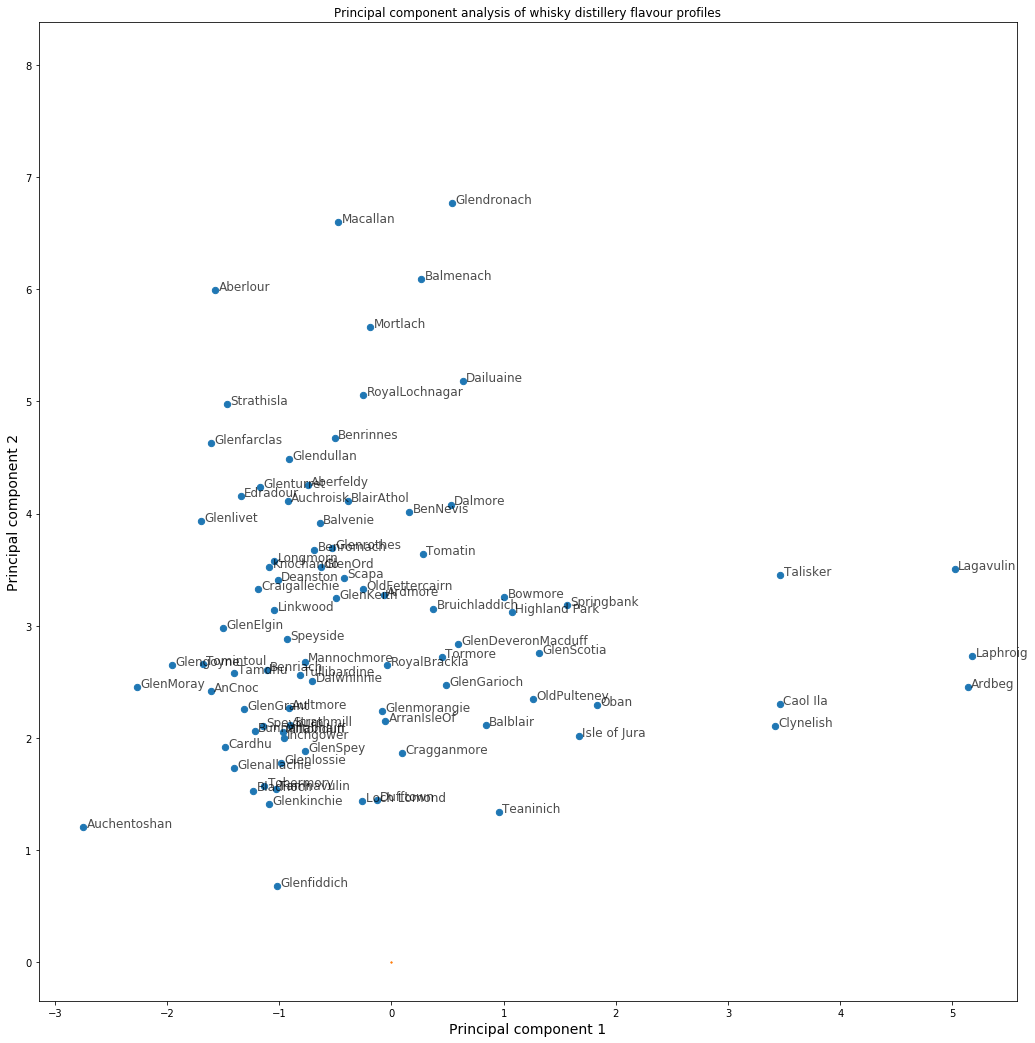

In [15]:
## Show the whisky distilleries laid out
## on the two first principal components,
## (just to see that similar whiskies are indeed clustered together)

fig_a2 = plt.figure(figsize=(18,18)) # do not change the name of this figure!
ax = fig_a2.add_subplot(1,1,1) 
#ax.set_frame_on(False)
ax.set_xlabel("Principal component 1", fontsize=14)
ax.set_ylabel("Principal component 2", fontsize=14)
ax.set_title("Principal component analysis of whisky distillery flavour profiles", fontsize=12)
ax.scatter(whisky_projected_2d[:,0], whisky_projected_2d[:,1], s=40)
ax.scatter((0,0), (0,0), s=1)
for i,name in enumerate(distilleries):
    ax.text(whisky_projected_2d[i,0]+0.03, whisky_projected_2d[i,1], name, fontdict={'size':12},alpha=0.7)
ax.axis('square') # this is important (we will compromise and let the axis be a bit stange)


In [16]:
## Visible test with feedback (4 marks) that test your whisky_projected_2d computation



with tick.marks(4):
    assert(check_hash(whisky_projected_2d, ((86, 2), 21159.91633246404)))

**Task A.3 [manually graded; model-solution will be made available]**

We will now consider colour coding the data points by one of their aspects/features.

You must establish the principle components for the `demeaned_whisky` and project the `demeaned_whisky` onto the first two (ordered) principal components (as we did for the `whisky`)? The figure must include the same information as the one above but additionally contain a colouring of the data points according to the value of the "medicinal" feature. 
        
You must furthermore provide a variable `A3_EXPLANATION` in which you outline your interpretation of the results [max 200 words] including;
- argue if your projection provides a clear distinction of "medicial" and non-"medicial" tasting whiskies. 
- how is your result releated to the eigenvectors and eigenvalues, i.e is this expected ? 
- is there a difference between the projection of the `demeaned_whisky` vs the `whisky` data. 
- any other comments you have regarding the results.


(86, 2)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


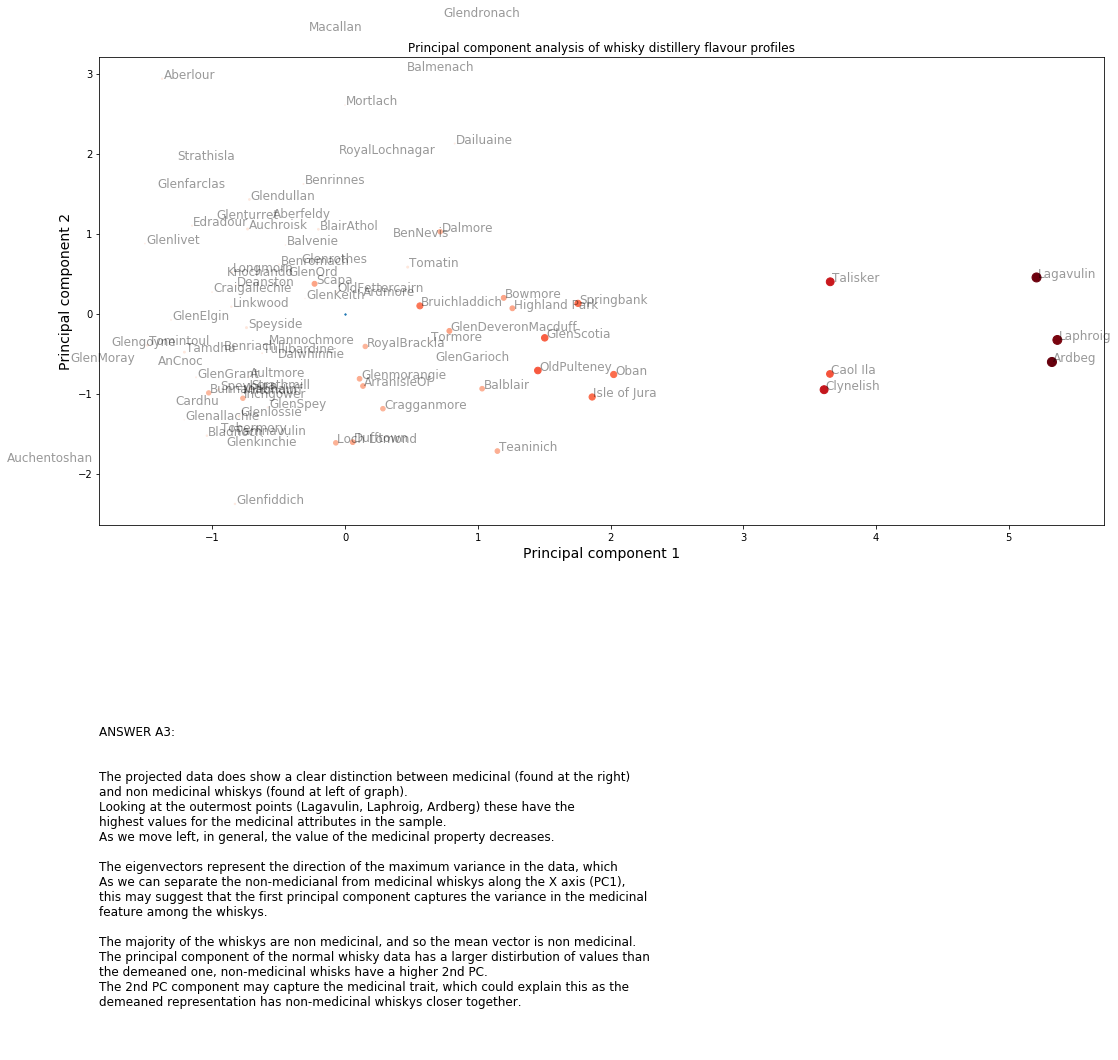

In [17]:
###################################################
fig_a3 = plt.figure(figsize=(18,18)) # do not chang ethe name of this figure!
ax = fig_a3.add_subplot(4,1,(1,2)) # do not change this (this will allow your explanation/caption to be added below the figure)
###################################################

A3_EXPLANATION = """

The projected data does show a clear distinction between medicinal (found at the right) 
and non medicinal whiskys (found at left of graph). 
Looking at the outermost points (Lagavulin, Laphroig, Ardberg) these have the
highest values for the medicinal attributes in the sample. 
As we move left, in general, the value of the medicinal property decreases. 

The eigenvectors represent the direction of the maximum variance in the data, which
As we can separate the non-medicianal from medicinal whiskys along the X axis (PC1), 
this may suggest that the first principal component captures the variance in the medicinal 
feature among the whiskys. 

The majority of the whiskys are non medicinal, and so the mean vector is non medicinal. 
The principal component of the normal whisky data has a larger distirbution of values than 
the demeaned one, non-medicinal whisks have a higher 2nd PC. 
The 2nd PC component may capture the medicinal trait, which could explain this as the 
demeaned representation has non-medicinal whiskys closer together.  

"""

# add your plots to the ax handle, e.g. ax.scatter(...)


medicinal_vals = whisky.T[3]
medicinal_vals

demeaned_medicinal = demeaned_whisky.T[3]


pj = demeaned_whisky @ pcs
demeaned_whisky_projected_2d = pj
print(whisky_projected_2d.shape)

ax.set_xlabel("Principal component 1", fontsize=14)
ax.set_ylabel("Principal component 2", fontsize=14)
ax.set_title("Principal component analysis of whisky distillery flavour profiles", fontsize=12)
ax.scatter(demeaned_whisky_projected_2d[:,0], demeaned_whisky_projected_2d[:,1], cmap='Reds', c=medicinal_vals, s=20*medicinal_vals)
ax.scatter((0,0), (0,0), s=1)
for i,name in enumerate(distilleries):
    ax.text(demeaned_whisky_projected_2d[i,0]+0.01, demeaned_whisky_projected_2d[i,1], 
            name, fontdict={'size':12},alpha=0.4)




###################################################
### This adds your text (do not change this!)
ax = fig_a3.add_subplot(4,1,(3,4))
ax.axis('off')
try:
    ax.text(0,0,("ANSWER A3:\n%s" % A3_EXPLANATION), fontsize=12)
except:
    ax.text(0,0,"ERROR A3_EXPLANATION NOT PROVIDED") 
    raise NotImplemented() # this is to give you an option to define A3_EXPLANATION above! 
###################################################


In [18]:
## Manually graded without immediate feedback (8 marks)




We can normalise this data further. Whiten the dataset so that it removes the mean and any correlation in the data. This is particularly useful if we are going to try and map from data in one vector space to another; having the data in standard scaling, with no offset and no correlation among dimensions makes the data easier to work with.

**Task A.4**
Use the SVD to compute the inverse square root of the covariance matrix `whisky_cov`. Multiply the demeaned whisky matrix by this to produce `whitened_whisky`. This represents the data with the mean removed and all correlations eliminated.

*Hint*: A.5 provides you with some hints about how to check that you have done this correctly.

In [19]:
u, sigma, vt = np.linalg.svd(np.cov(demeaned_whisky, rowvar=False))
sigma_inv_sqr = vt.T @ np.diag(1.0 / np.sqrt(sigma)) @ u.T
whitened_whisky = demeaned_whisky @ sigma_inv_sqr

In [20]:
## Sanity check that the shape of your whitened_whisky is correct
with tick.marks(0):
    assert(check_hash(0*whitened_whisky, ((86, 12), 0.0)))

In [21]:
## Hidden test checks the full whitened_whisky matrix (10 marks)



**Task A.5**

Produce a (composite) figure with two subplots which illustrates certain properties of the whitened data. It must include 
- a subplot visualising the mean vector of the whitened data (`ax1`)
- a subplot visualising the covarince matrix of the whitened data (`ax2`)

You must additionally provide argumentation and justificaiton for how you can tell that the data has been whitened (based on the figure). It should be stored in `A5_EXPLANATION`. Maximum 100 words.

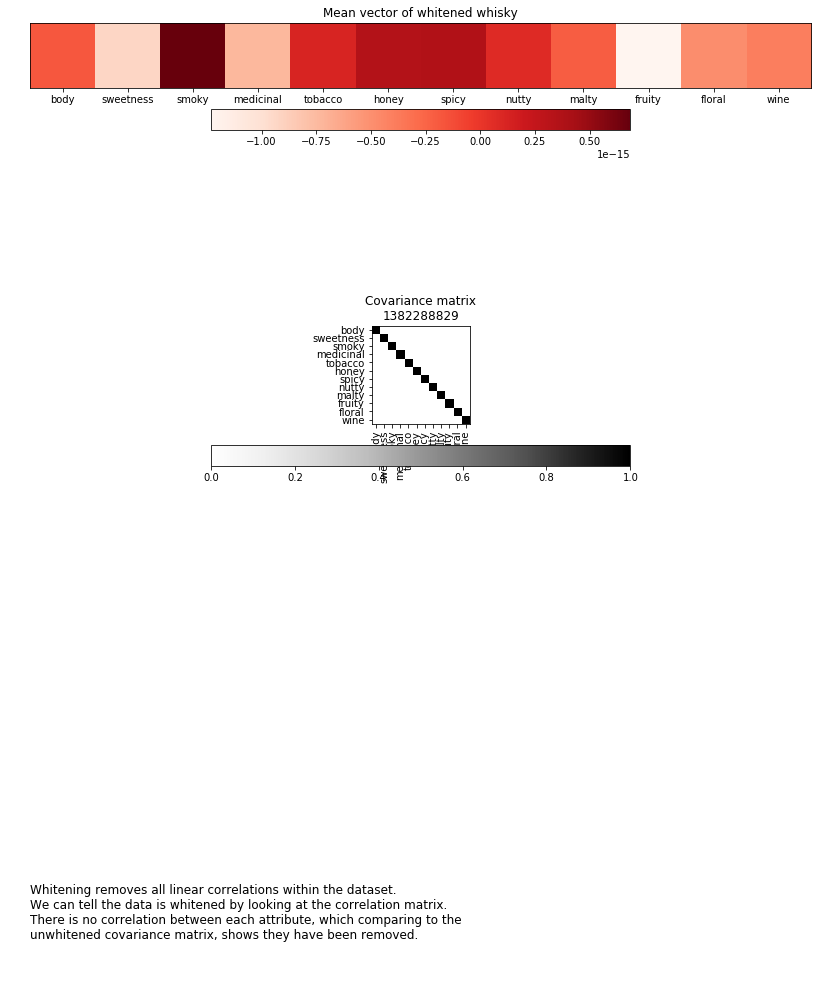

In [24]:
###################################################
## Setup up the figure [do not change this first part]
fig_a5 = plt.figure(figsize=(14,18)) # DO NOT MODIFY
ax1 = fig_a5.add_subplot(6,1,1) # DO NOT MODIFY
ax2 = fig_a5.add_subplot(6,1,3) # DO NOT MODIFY
###################################################
## Start you solution here by adding content to ax1, ax2 etc...

A5_EXPLANATION = """

Whitening removes all linear correlations within the dataset. 
We can tell the data is whitened by looking at the correlation matrix. 
There is no correlation between each attribute, which comparing to the 
unwhitened covariance matrix, shows they have been removed.

"""


mean_whitened = np.mean(whitened_whisky, axis=0)
cov_whitened =  np.cov(whitened_whisky, rowvar=False) 

img = ax1.imshow(mean_whitened[None,:], cmap='Reds')
ax1.set_xticklabels(columns)
ax1.set_xticks(np.arange(len(columns)))
ax1.set_yticks([])
ax1.set_title("Mean vector of whitened whisky")
fig.colorbar(img, ax=ax1,orientation='horizontal')

img2 = ax2.imshow(cov_whitened, cmap='Greys')
ax2.set_xticks(np.arange(12))
ax2.set_yticks(np.arange(12))
ax2.set_yticklabels(columns)
ax2.set_xticklabels(columns, rotation='vertical')
ax2.set_title(("Covariance matrix\n%s") % (uuid_system))
# resize the figure to match the aspect ratio of the Axes   
fig.set_size_inches(7,8, forward=True)
fig.colorbar(img2, ax=ax2, orientation='horizontal')


###################################################
## Do not not change this (adds your explanation to the fig/pdf)
# Adds you text tothe bottom of the figure
axtxt = fig_a5.add_subplot(6,1,6)  # DO NOT MODIFY
axtxt.axis('off')  # DO NOT MODIFY
try:
    axtxt.text(0,0,A5_EXPLANATION, fontsize=12)
except:
    axtxt.text(0,0,"WARNING A5_EXPLANATION NOT PROVIDED")

In [23]:
## Hidden test, manually graded based on produced pdf (4 marks)



---
We can also illustrate the whitened data as an image:

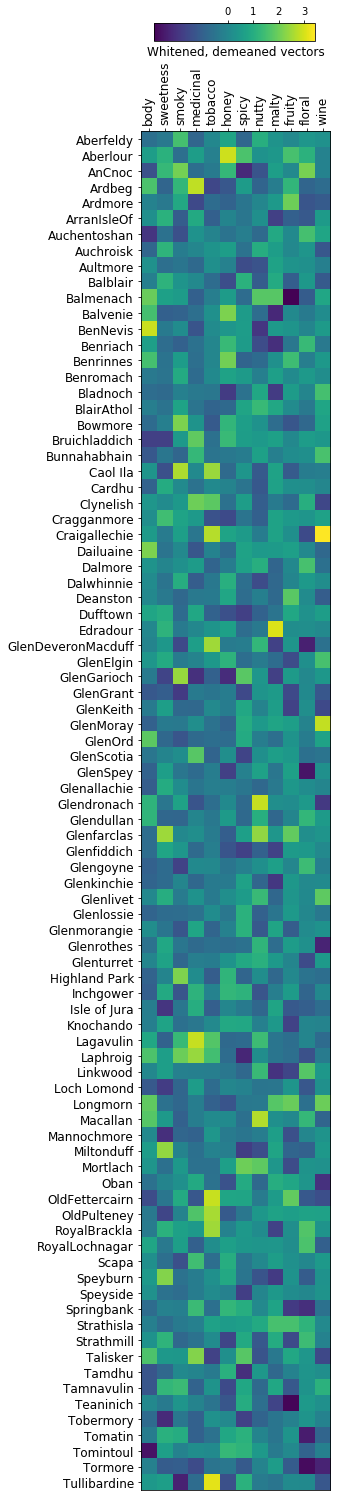

In [25]:
#### show a plot of the whisky data
fig = plt.figure(figsize=(8,25))
ax = fig.add_subplot(1,1,1)
ax.set_title("Whitened, demeaned vectors")
# image plot
img = ax.imshow(whitened_whisky)
ax.set_yticks(np.arange(len(distilleries)))
ax.set_yticklabels(distilleries, rotation="horizontal", fontsize=12)

# put the x axis at the top
ax.xaxis.tick_top()
ax.set_xticks(np.arange(len(columns)))
ax.set_xticklabels(columns, rotation="vertical", fontsize=12)

# some horrific colorbar hackery to put in the right place
# don't worry about this bit!
cbaxes = fig.add_axes([0.37, 0.93, 0.28, 0.01])  
fig.colorbar(img, orientation='horizontal',  cax=cbaxes, ticks=np.arange(5))
cbaxes.xaxis.tick_top()


### Visualising in normalised space
Now that we have the data whitend, we could also define a more sensible way to compare vectors in a high-dimensional space. The $L_2$ norm has significant problems in very high-dimensional spaces. A more sensible way to compare high-dimensional vectors is to look at the *angle* between them.

**Task A.6**
Define a function `cosine(a, b)` that computes the cosine of the angle between two vectors `a` and `b` usign only `np.dot` and `np.norm`.

N.B. This should be a value between -1 and 1.

In [26]:
def cosine(a,b):
    top = np.dot(a,b)
    bottom = np.linalg.norm(a)*np.linalg.norm(b)
    return top/bottom
    

In [27]:
## Visible test (3 marks)
# Note if this fails it means that either your cosine function or the whitened_whisky is wrong - or possibly both! 


# Compute the angels between all vectors 
angles = np.array([cosine(whitened_whisky[i,:], whitened_whisky[j,:]) for i in range(len(whisky)) for j in range(len(whisky))])

# Check
with tick.marks(3):
    assert(check_hash(angles, ((7396,), 25457.146694199713)))



#### Demo: A 3D visualisation
We can use this to show a different layout of whiskies; this time in terms of relative angles to two reference distillieries, in the whitened space. This has the advantage that all distances are normalised to the range [-1,1], and we have a good spread of points in the space. The plot below shows the angle with respect to 3 distilleries, as a 3D plot. Tou can compare with the plot using the unwhitened data to see the effect that normalisation has had, if you wish.

This is also an example of why visualising data in 3D is usually a bad idea.

Text(0.5, 0.92, 'Normalised flavour angles between whisky distilleries')

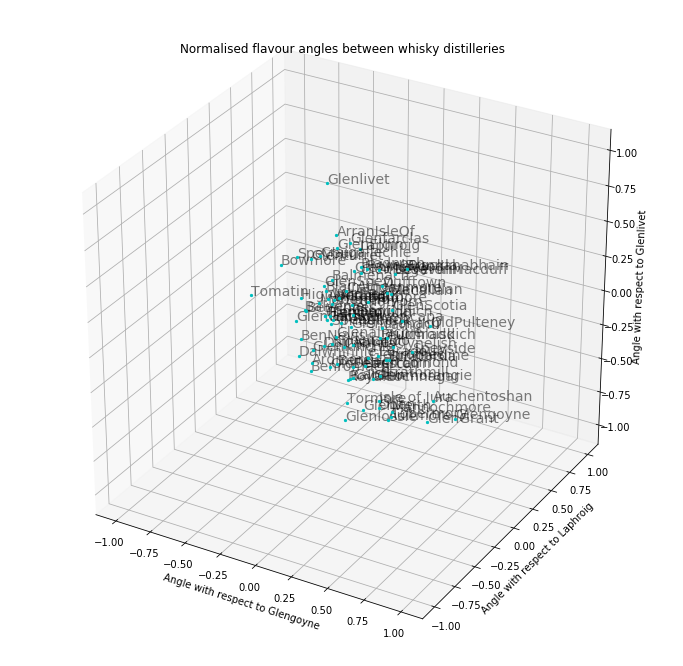

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook
import matplotlib.pyplot as plt
#%matplotlib notebook

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1,1,1, projection='3d')

## Modify these to plot the flavours on different axes
ref_a = 'Glengoyne'
ref_b = 'Laphroig'
ref_c = 'Glenlivet'

## get the respective flavour vectors
reference_a = whitened_whisky[distilleries.searchsorted(ref_a)]
reference_b = whitened_whisky[distilleries.searchsorted(ref_b)]
reference_c = whitened_whisky[distilleries.searchsorted(ref_c)]

for name, flavour in zip(distilleries, whitened_whisky):
    ## compute angles to the references
    angle_a = cosine(reference_a, flavour)
    angle_b = cosine(reference_b, flavour)
    angle_c = cosine(reference_c, flavour)

    ax.scatter(angle_a, angle_b, angle_c, color='c', s=5)
    ax.text(angle_a, angle_b, angle_c, name, fontdict={"size":14}, alpha=0.5)
    
## fix up the plot
ax.set_xlabel("Angle with respect to {ref_a}".format(ref_a=ref_a))
ax.set_ylabel("Angle with respect to {ref_b}".format(ref_b=ref_b))
ax.set_zlabel("Angle with respect to {ref_c}".format(ref_c=ref_c))
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_zlim(-1.1, 1.1)
ax.set_title("Normalised flavour angles between whisky distilleries")

## Analysis and visualisation of 3D PCA projections (via 2D scatter plots)
*Note*: This is an exploratory and open-ended question marked on the produced figure (i.e. is it a sensible figure that illustrated the main aspects) and are justificaitons inine with what we know about the principle components.

**Task A.7**
While 3D plots are sometimes difficult to understand they are often used to visualise PCA in exploratory analysis. To see if we can gain some insight from 3D projections (albeit not visualisaitons) you must project the `demeaned_whisky` onto the first **three** principal components and we'll then visualise the results in a structured set of 2D plots.


In [29]:
pcs_3 = whisky_pc[:,0:3]
print(pcs_3.shape)

demeaned_whisky_projected_3d= demeaned_whisky @ pcs_3
print(demeaned_whisky_projected_3d.shape)

(12, 3)
(86, 3)


In [30]:
## Visible test [4 marks] 
# Note if this fails it means that either your cosine function or the whitened_whisky is wrong - or possibly both! 


# Check
with tick.marks(4):
    assert(check_hash(demeaned_whisky_projected_3d, ((86, 3), 70.9840123079923)))

**Task A.8**

3D scatter plots are sometimes useful when analysing 3D PCA data (you can try) but not very easy to interpret. We will instead explore an alternative and standard way of visualising PCA projections. Correctly, we plot multiple 2D scatter plots, including PC1 vs PC2, PC1 vs PC2 and PC2 Vs PC3 and so on.

A template is provided below and you must now complete the function and produce a figure (`fig_a8`) that
 - does not contain any labels (or only few) for the distilleries (we have seen that they mess up the plot).
 - has 'colour_scaling' intended to scale colour based on the value of `medicinal` feature.
 - has 'marker_scaling' intended to scale marker size based on the value of `spicy` feature. 
This is to gain specific insights into the data and the relationship with the principal components.

*Hint*: it can be helpful starting out with `colour_scaling` and `marker_scaling`  being based on the same aspect (e.g., `medicinal`).

Additionally, you must provide a concise, correct, coherent analysis and explanation stored in `A8_EXPLANATION`. You may want to consider if the results reflect what we know about the principal components (provide arguments and justification ).
  

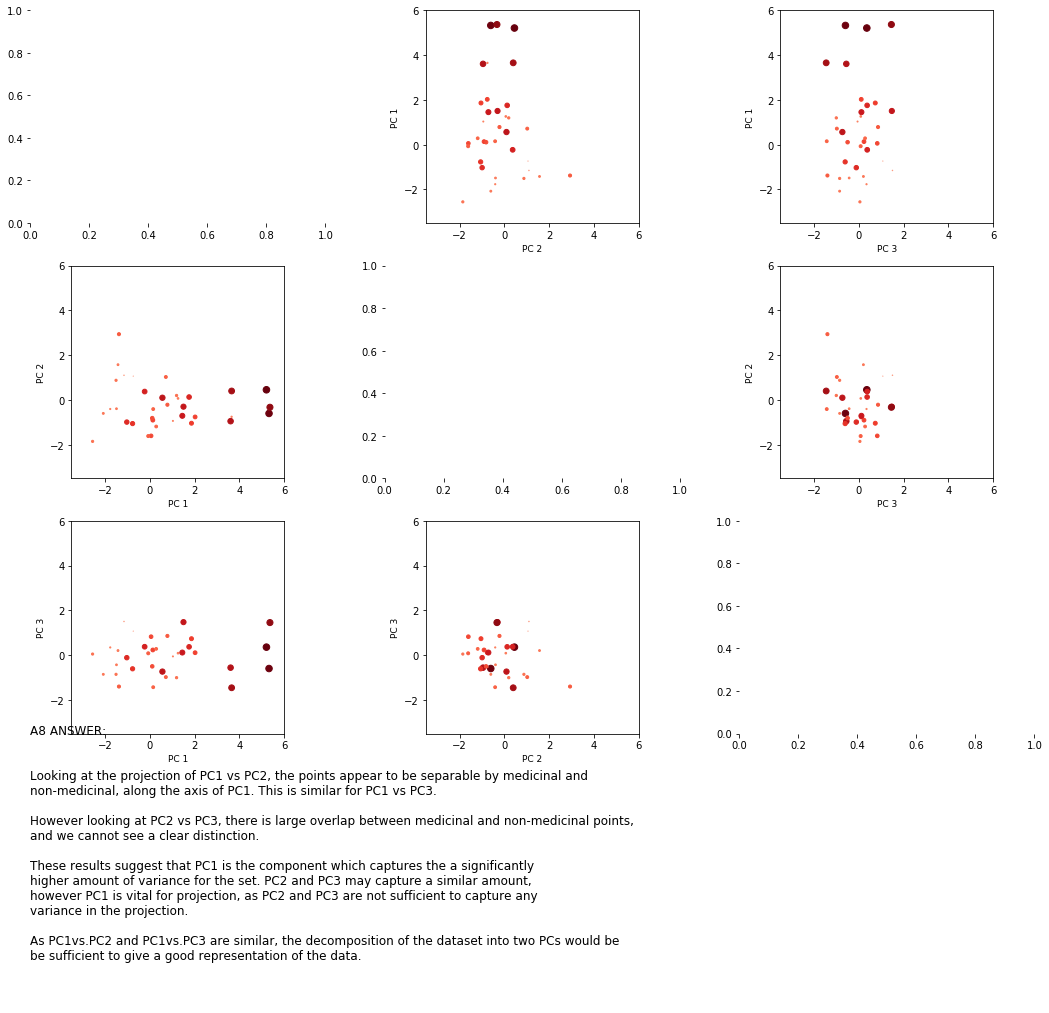

In [31]:
###################################################
## Setup the ax handels - DO NOT MODIFY!
fig_a8 = plt.figure(figsize=(18,18)) # do not change the name of this figure!
ax = dict()
cnt=1
for i in range(3):
    for j in range(3):
        ax[i,j] = fig_a8.add_subplot(4,3,cnt) # do not change this (this will allow your explanation/caption to be added below the figure)
        cnt+=1
axtxt = fig_a8.add_subplot(4,3,(10,12)) # an axis where we will add your explanation
axtxt.axis('off')
###################################################

A8_EXPLANATION = """

Looking at the projection of PC1 vs PC2, the points appear to be separable by medicinal and
non-medicinal, along the axis of PC1. This is similar for PC1 vs PC3. 

However looking at PC2 vs PC3, there is large overlap between medicinal and non-medicinal points,
and we cannot see a clear distinction.

These results suggest that PC1 is the component which captures the a significantly 
higher amount of variance for the set. PC2 and PC3 may capture a similar amount, 
however PC1 is vital for projection, as PC2 and PC3 are not sufficient to capture any 
variance in the projection. 

As PC1vs.PC2 and PC1vs.PC3 are similar, the decomposition of the dataset into two PCs would be 
be sufficient to give a good representation of the data. 

"""

medicinal_vec = whitened_whisky.T[3]
medicinal_vec

cnt=0
for i in range(3):
    for j in range(3):
        ### PC i vs j       
        if not i==j:
            ax[j,i].set_xlabel(("PC %s" % (i+1)), fontsize=9)
            ax[j,i].set_ylabel(("PC %s" % (j+1)), fontsize=9)
                               
            # Hint...:    
            colour_scaling = medicinal_vec         
            marker_scaling = 15*medicinal_vec 

            ax[j,i].scatter(demeaned_whisky_projected_3d[:,i], 
                            demeaned_whisky_projected_3d[:,j],
                            c=colour_scaling, # you must provide this!
                            s=marker_scaling,
                            cmap='Reds'# you must provide this!
                           )

            ax[j,i].set_aspect('equal', adjustable='box')
            ax[j,i].axis('square')
            ax[j,i].set_xlim((-3.5,6))
            ax[j,i].set_ylim((-3.5,6))  
            ax[j,i].set_frame_on(True)
        else:
            ax[j,i].set_frame_on(False)


            

#######################################################
## This adds your explanation in A8_EXPLANATIONto the figure (do not change this!)
try:
    axtxt.text(0,0,("A8 ANSWER:\n %s " %  A8_EXPLANATION), fontsize=12)
except:
    axtxt.text(0,0,"ERROR A8_EXPLANATION NOT PROVIDED") 
    raise NotImplemented() # this is to give you an option to define A3_EXPLANATION above! 
#######################################################    


In [32]:
## Hidden test, manually graded based on produced pdf (10 marks)



---

## B: Solving linear systems 

Consider the following problem: A newly founded distillery aims to produce a Whisky similar to "Glenlivet" but would like 2.5 points more "body", 0.1 points more "sweetness" and 0.2 points fewer on the "tobacco" scale - otherwise, they are happy with the Glenlivit flavor profile.

Is it possible for the distillery to produce this Whisky given their current production system with limited production capabilities (modeled as a *linear system*)?


**Task B.1**
- Extract the flavour profile for Glenlivit from `demeaned_whisky` and store it in `demeaned_glenlivit`
- Compute the new target flavour profile (based on the `demeaned_glenlivit`) the new distilley is aiming for; store it in `demeaned_desired_flavour`

In [33]:
demeaned_glenlivit = demeaned_whisky[distilleries.searchsorted('Glenlivet')]
demeaned_glenlivit

array([-0.05753513,  0.82744385, -0.48467562, -0.54550412, -0.09853845,
        0.56058325,  0.57891941,  1.14870996, -0.54324323,  0.32874084,
        0.33630525,  1.42430991])

In [34]:
demeaned_new_flavour = demeaned_glenlivit.copy()
demeaned_new_flavour[0]=demeaned_new_flavour[0]+2.5
demeaned_new_flavour[1]=demeaned_new_flavour[1]+0.1
demeaned_new_flavour[4]=demeaned_new_flavour[4]-0.2


print(demeaned_glenlivit)
print()
print(demeaned_new_flavour)

demeaned_desired_flavour = demeaned_new_flavour

[-0.05753513  0.82744385 -0.48467562 -0.54550412 -0.09853845  0.56058325
  0.57891941  1.14870996 -0.54324323  0.32874084  0.33630525  1.42430991]

[ 2.44246487  0.92744385 -0.48467562 -0.54550412 -0.29853845  0.56058325
  0.57891941  1.14870996 -0.54324323  0.32874084  0.33630525  1.42430991]


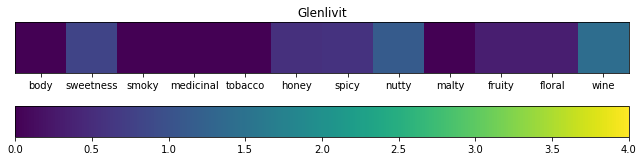

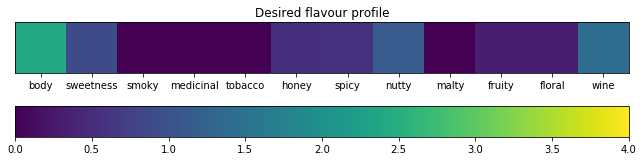

In [35]:
## Show the demeaned_glenlivit vector as an image strip
## Remember: this represents a point in space
fig = plt.figure(figsize=(11, 4))
ax = fig.add_subplot(1,1,1)
img = ax.imshow(demeaned_glenlivit[None,:], cmap='viridis', vmin=0, vmax=4)
ax.set_xticklabels(columns)
ax.set_xticks(np.arange(len(columns)))
ax.set_yticks([])
ax.set_title("Glenlivit")
fig.colorbar(img, orientation='horizontal')

## Show the demeaned_glenlivit vector as an image strip
fig = plt.figure(figsize=(11, 4))
ax = fig.add_subplot(1,1,1)
img = ax.imshow(demeaned_desired_flavour[None,:], cmap='viridis', vmin=0, vmax=4)
ax.set_xticklabels(columns)
ax.set_xticks(np.arange(len(columns)))
ax.set_yticks([])
ax.set_title("Desired flavour profile")
fig.colorbar(img, orientation='horizontal')


In [36]:


# Check
with tick.marks(2):
    assert(check_hash(demeaned_glenlivit, ((12,), 35.3928040241586)))

In [37]:


with tick.marks(2):
    assert(check_hash(demeaned_desired_flavour, ((12,), 38.66863915527948)))

**Task B.2**

The new distillery has a new but simple production facility and only limited access to quality ingredients (specific malt types), which limits their flexibility. They only have five specific parameters they can easily control, such as the age of the barrels in which they age the whiskey and certain pressure and temperature settings during the distillation and aging. In total, they have five such (continuous) parameters, which we can **conveniently** collect in a vector $\mathbf{x}\in\mathbb{R}^5$; each parameter has a unique effect on the resulting flavor.

We also happen to know a set of equations govering the input-output relationship of the current Whisky distillery. When we  produce our Whisky with a certain $\mathbf{x}$ as input, we know the result of the distillation in terms of the flavors. The input-output relations are given by the follwing equations:

$$\begin{gathered}
  {y_1} = {x_1}{\text{  + }}{x_2}{\text{  +  }}{x_5}{\text{ }} \hfill \\
  -2{x_1}+{y_2} = {x_2}{\text{  + }}{x_3}{\text{ }} - {x_4}{\text{ +  }}{x_5}{\text{ }} \hfill \\
  {y_3} =  - 2{x_1}{\text{  + }}{x_2}{\text{ +  }}{x_3}{\text{  + }}{x_4}{\text{ }} - {x_5} \hfill \\
  {y_4} = {x_1}{\text{ }} + {x_2}{\text{  + }}{x_3}{\text{ }} - 2{x_4}{\text{  }} \hfill \\
  {y_5} =  - {x_5}{\text{ }} \hfill \\
  {y_6} =  - {x_1}{\text{  +  }}{x_2}{\text{ }} - {x_3}{\text{ +  }}{x_5} \hfill \\
  -{x_2}{\text{ -  }}{x_3}{\text{ }}+ {y_7} = 0 \hfill \\
  {y_8} = {x_2}{\text{ }} - {x_3}{\text{  +  }}2{x_5} \hfill \\
  {y_9} = 4{x_1}{\text{  + }}{x_2} - {x_3}{\text{ }} - {x_4}{\text{ }} - {x_5} \hfill \\
  {y_{10}} = 3{x_1}{\text{ }} - {x_2}{\text{ }} - {x_3} \hfill \\
  {y_{11}} =  - {x_1}{\text{  + }}{x_2}{\text{ }} - 3{x_3} \hfill \\
  {y_{12}} = 3{x_1}{\text{  + }}2{x_2}{\text{  +  }}{x_3}{\text{  +  }}{x_4}{\text{  + }}{x_5} \hfill \\ 
\end{gathered} $$

Where $\mathbf{x}=[x_1,x_2,...,x_{12}]$ are the parameters and $\mathbf{y}=[y_1,y_2,...,y_{12}]$ is the desired flavor profile. For example, if we know the value of the system parameters $x_1$ and $x_2$ and $x_5$ we know what the "body" of the Whisky will be once it has finished aging and has been bottled.

In short, when we apply the set of equations to our process parameters vector, $\mathbf{x}$, we know the resulting flavour. This is a *system of linear equations* (or just a *linear system*) which can be written $A\mathbf{x} = \mathbf{y}$ where $\mathbf{y}$ is the vector stored in `demeaned_desired_flavour` and $\mathbf{x}$ is the vector of parameters we need to produce a whisky with a certain flavour profile.



**Task B.3**

From the set of coupled equations above, identify $A$ (this is a manual task but important to understand ) and create a $12x5$ matrix, and store it in a numpy array called `A_whisky_process.` It should have values such that we can apply it to $\mathbf{x}$ and get $\mathbf{y}$, i.e., $A\mathbf{x} = \mathbf{y}$ where $\mathbf{y}$ is the vector `demeaned_desired_flavour`. You should not be applying any manual solving techniques to $A$ and $\mathbf{y}$ but simply inspect the individual equations and identify the correct values of the corresponding row in $A$.

In [38]:
A_whisky_process = np.array([
    [1,1,0,0,1], #y1
    [2,1,1,-1,1], #y2
    [-2,1,1,1,-1], #y3
    [1,1,1,-2,0], #y4
    [0,0,0,0,-1], #y5
    [-1,1,-1,0,1], #y6
    [0,1,1,0,0], #y7
    [0,1,-1,0,2], #y8
    [4,1,-1,-1,-1], #y9
    [3,-1,-1,0,0], #y10
    [-1,1,-3,0,0], #y11
    [3,2,1,1,1]]) #y12


A_whisky_process

array([[ 1,  1,  0,  0,  1],
       [ 2,  1,  1, -1,  1],
       [-2,  1,  1,  1, -1],
       [ 1,  1,  1, -2,  0],
       [ 0,  0,  0,  0, -1],
       [-1,  1, -1,  0,  1],
       [ 0,  1,  1,  0,  0],
       [ 0,  1, -1,  0,  2],
       [ 4,  1, -1, -1, -1],
       [ 3, -1, -1,  0,  0],
       [-1,  1, -3,  0,  0],
       [ 3,  2,  1,  1,  1]])

In [39]:
## Sanity check - size of A_whisky_process (0 marks)
with tick.marks(0): # a better test/hash
    assert(check_hash( 0*A_whisky_process , ((12, 5), 0)))

In [40]:
## Visible, autograded assesment (advanced hash - WARNING: does not check the correct size of A_whisky_process)


with tick.marks(5): # ADVANCED HASH; DOES NOT CHECK FOR CORRET SIZE OF A_whisky_process
    assert(check_hash( A_whisky_process @ (np.linspace(1,2515.337,12*5)).reshape((5,12)), ((12, 12), 8064117.670669426)))

**Task B.4**

We now look to find the set of ingedients and process parameters (i.e. $\mathbf{x})$ that will (hopefully) result in the new distillery being able to produce the new flavour.

$A$ is asymmetrical and this problem does not have an exact solution. We can however use the pseudo-inverse to give the closest result according to the L2 norm. In other words, it will find the vector $\mathbf{\hat x}$ that minimises the distance $\left\| {A\mathbf{\hat x}−\mathbf{y}} \right\|_2$:

- use `np.linalg.pinv` to compute an estimate the of process parameters, $\mathbf{\hat x}$, such that $A \mathbf{\hat x}\approx \mathbf{y}$ you'll need to use to produce the Whisky with the desired flavour (see the lecture notes on the pseudo inverse). Store the result in `xhat`.
- compute the actual flavour resulting from using the process parameters, $ \mathbf{\hat x}$, and store it in `demeaned_actual_flavour`.
- compute the L2 norm of the error and store it in `error_l2`.


In [41]:
A_pinv = np.linalg.pinv(A_whisky_process) 
xhat = A_pinv @ demeaned_desired_flavour

demeaned_actual_flavour = A_whisky_process @ xhat

error_l2 = 

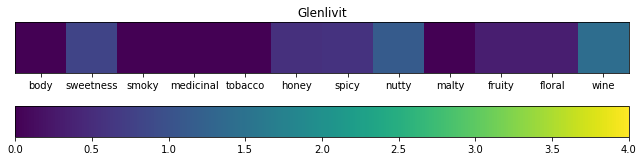

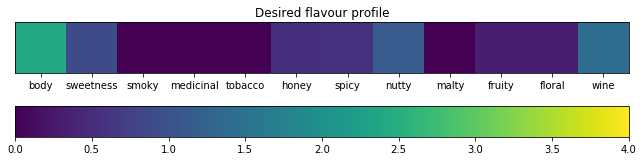

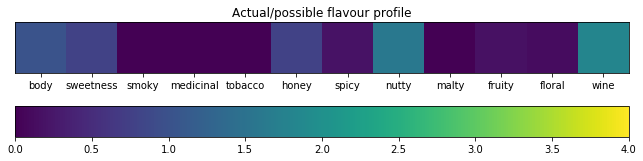

In [44]:
## Show the demeaned_glenlivit vector as an image strip
## Remember: this represents a point in space
fig = plt.figure(figsize=(11, 4))
ax = fig.add_subplot(1,1,1)
img = ax.imshow(demeaned_glenlivit[None,:], cmap='viridis', vmin=0, vmax=4)
ax.set_xticklabels(columns)
ax.set_xticks(np.arange(len(columns)))
ax.set_yticks([])
ax.set_title("Glenlivit")
fig.colorbar(img, orientation='horizontal')

## Show the demeaned_desired_flavour vector as an image strip
fig = plt.figure(figsize=(11, 4))
ax = fig.add_subplot(1,1,1)
img = ax.imshow(demeaned_desired_flavour[None,:], cmap='viridis', vmin=0, vmax=4)
ax.set_xticklabels(columns)
ax.set_xticks(np.arange(len(columns)))
ax.set_yticks([])
ax.set_title("Desired flavour profile")
fig.colorbar(img, orientation='horizontal')

## Show the demeaned_actual_flavour vector as an image strip
fig = plt.figure(figsize=(11, 4))
ax = fig.add_subplot(1,1,1)
img = ax.imshow(demeaned_actual_flavour[None,:], cmap='viridis', vmin=0, vmax=4)
ax.set_xticklabels(columns)
ax.set_xticks(np.arange(len(columns)))
ax.set_yticks([])
ax.set_title("Actual/possible flavour profile")
fig.colorbar(img, orientation='horizontal')

In [43]:
## Visible, autograded assesment of xhat (4 marks)


with tick.marks(4):    
    assert(check_hash(xhat, ((5,), 6.687251368076565)))

In [ ]:
## Hidden, autograded assesment of the error_l2 variable (2 marks)



We can now (hopefully) answer the question whether the newly founded distillery is currently able to produce a Whisky with the desired flavor profile - or should they perhaps look to improve their production facilities (or choose a different business entirely)...?


---

# Submission on Moodle


We will generate the **one** pdf file you'll need to submit along with the notebook:

*Note*: you do not need to worry about the formatting etc (that's predetermined); just make sure all your explanations are readable in the pdf and your'll be fine!


In [45]:
## Report generation - YOU MUST YOU RUN THIS CELL !
#
# This part will generate a combined pdf of your work for the manual assesment
#
# It is your responsibility to check that the PDF version represents your answer before uploading to Moodle!
#
# Ignore warnings regarding fonts
#

from matplotlib.backends.backend_pdf import PdfPages

# File 1: declaration of originality with system info
try:
    f = open('uofg_declaration_of_originality.txt','r')
    uofg_declaration_of_originality = f.read()
except: 
    uofg_declaration_of_originality = "uofg_declaration_of_originality not present in cwd"

try:
    student_id.lower()
except: 
    student_id="NORESPONSE"
try:
    student_typewritten_signature.lower()
except: 
    student_typewritten_signature="NORESPONSE"

fn = ("idss_lab_topic_02_complinalg_%s_declaration.pdf" % (student_id.lower()))
fig_dec = plt.figure(figsize=(10, 12)) 
fig_dec.text(0.1,0.1,("%s\n\n Student Id %s\n\n Typewritten signature: %s\n\n UUID System: %s" % (uofg_declaration_of_originality,student_id, student_typewritten_signature, uuid_system)))
fig_dec.savefig(fn, bbox_inches='tight') 
 
# A.1: Figure 
fn = ("idss_lab_topic_02_complinalg_%s_a1_answer.pdf" % (student_id))
fig_a1.savefig(fn)
    
# A.3: Figure 
fn = ("idss_lab_topic_02_complinalg_%s_a3_answer.pdf" % (student_id))
fig_a3.savefig(fn)

# A.4: Figure 
fn = ("idss_lab_topic_02_complinalg_%s_a4_answer.pdf" % (student_id))
fig_a5.savefig(fn)

# A.8: Figure 
fn = ("idss_lab_topic_02_complinalg_%s_a8_answer.pdf" % (student_id))
fig_a8.savefig(fn)


# Combined: 
fn = ("idss_lab_topic_02_complinalg_%s_combined_v20192020d.pdf" % (student_id))
pp = PdfPages(fn)
pp.savefig(fig_dec)
pp.savefig(fig_a1)
pp.savefig(fig_a3)
pp.savefig(fig_a5)
pp.savefig(fig_a8)
pp.close()

with tick.marks(0):  # have you generated the combied file...? you don't actually get any credit for this just confirmation that the file has been generated
    assert(os.path.exists(fn))


<Figure size 720x864 with 0 Axes>

**You must (for full or partial marks) submit via Moodle:**

- this notebook (completed) after "Restart and rerun all":
    - `idss_lab_topic_02_complinalg_v20192020d.ipynb`
    
- the combined pdf (autognerated) contaning the relevant figures and answers for the manual assesment
     - `idss_lab_topic_02_complinalg_[YOUR STUDENT ID]_combined_v20192020d.pdf`)
     - We will check the notebook if there are issues with the pdf version (very unlikely).


---

# Appendix: Marking Summary (and other metadata)
#### - make sure that the notebook runs without errors (remove/resolve the `raise NotImplementedError()`) and "Restart and Rerun All" cells to get a correct indication of your marks.

In [46]:


print("Marks total : ","68")
print("Marks visible (with feedback): ","34")
print("Marks hidden (without feedback): ","34")
print("Marks manually graded: ","22")
print("Marks autograded (hidden+visible): ","42")
print("\nThe fraction below displays your performance on the autograded part of the lab that's visible with feedback (only valid after `Restart and Run all`:")
tick.summarise_marks() # 
print("- the autograded (and visible) marks account for at least 50% of the total lab assesment.")



Marks total :  68
Marks visible (with feedback):  34
Marks hidden (without feedback):  34
Marks manually graded:  22
Marks autograded (hidden+visible):  42

The fraction below displays your performance on the autograded part of the lab that's visible with feedback (only valid after `Restart and Run all`:


- the autograded (and visible) marks account for at least 50% of the total lab assesment.


#### History and change log
- v20192020b: First release 
- v20192020c: Second release
    - Fixed minor problem with a confusing hash.
- v20192020d: Third release (2019/11/14)
    - Made hash in B1 even more robost to student mistakes (certain incorrect A's would pass the hash in B.1 only evident in B3 which can be confusing to some students). Minor typos